## S LOARKS matrix 
###### Author: Zimu Huo
###### Date: 07.2022

Seems like it is working, the artefact in the final image looks very similar to that of the image used in the article. 
The result is really good, you can get away with only 5 percent of the data. 

Notes: 
I don't understand why the formulation is so complicated. The pseudo-inverse matrix is unnecessary to me as you can easily compensate it in the adjoint operator. (and thats is what i did, the code is much much cleaner)

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Justin P. Haldar 
    Title: Low-Rank Modeling of Local -Space Neighborhoods (LORAKS) for Constrained MRI
    Link: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6678771

In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
from util.fft import *
from util.phantom import * 
from util.rank import *
import util.io as io
import random
import util.mask as undersample
from numpy import linalg as linalg
from util.SPARSE import *

In [2]:
filepath = '../../lib/resource/data/multicoil_1slice/meas_MID308_low_res_2dflash_FID17297.dat'
data = io.getCoilData(filepath) 
data = fft2c(rsos(ifft2c(data)))
[ny, nx] = data.shape
print(data.shape)

pymapVBVD version 0.4.8
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

read data:   0%|          | 0/256 [00:00<?, ?it/s]

(256, 256)


0.0202178955078125


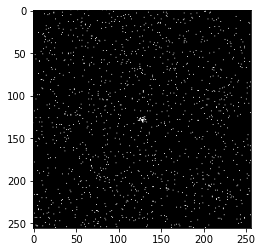

In [ ]:
def var_den_mask(shape, R):
    start = 1e-7
    end = 0.1
    for i in range(20):    
        cur = (start + end)/2
        mask = var_dens_mask([ny, nx], cur)
        curR = undersampling_rate(mask)
        print(curR, R)
        if curR < 1/R: 
            end = (start + end) /2
        else: 
            start = (start + end) /2
    return mask

mask = var_dens_mask([ny, nx], 0.00001)
print(undersampling_rate(mask))
show(mask)

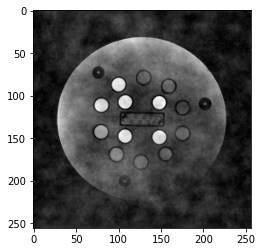

In [6]:
dataR = data * mask
show(ifft2c(dataR))

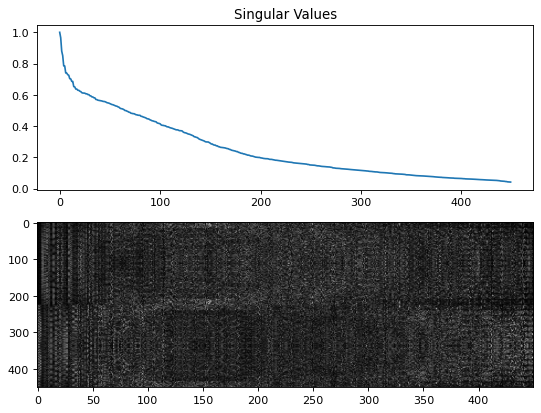

In [10]:
inspect_rank(LOARKS_S(dataR, 15))

In [12]:
import numpy.matlib
from scipy.linalg import block_diag
res = np.copy(dataR)
[ny, nx] = dataR.shape
rank = 200
k = 15

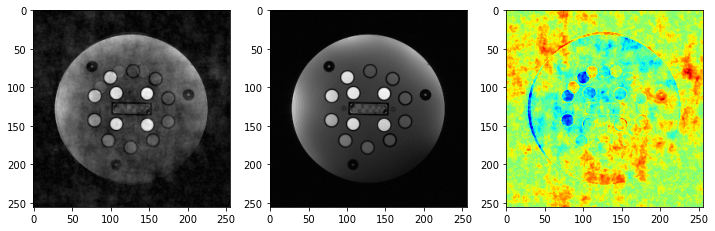

13.921031687656349


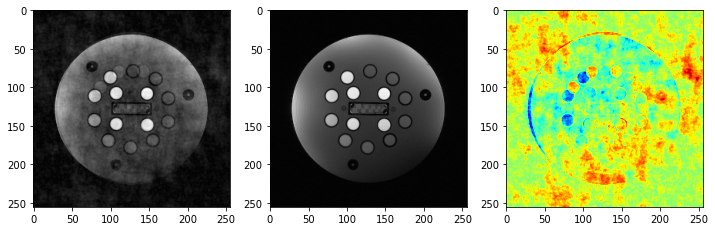

12.039548849941635


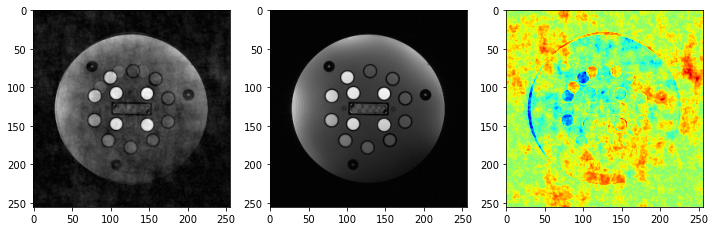

11.51917904784136


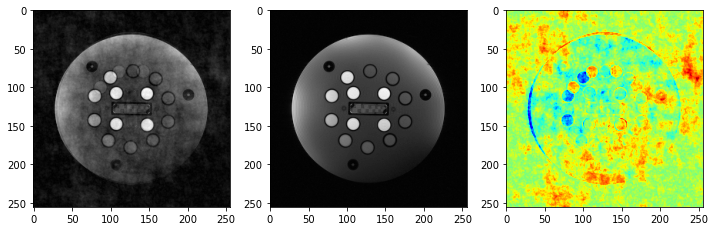

11.299321437787883


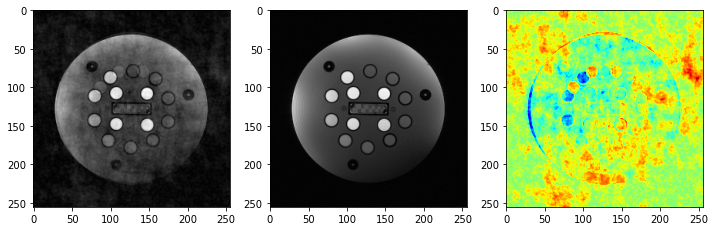

11.07810541357865


In [15]:
log = []
for i in range(50):
    C = LOARKS_C(res, k)
    Cr = rank_approx(C, rank)
    Kc = LOARKS_Cinv(Cr, k, data.shape)
    res = dataR + np.abs(1-mask) * Kc
    if i > 0:
        log.append(linalg.norm(res)-linalg.norm(prev))
    prev = res
    
    if (i % 10)==0: 
        plt.figure(figsize = (12, 8))
        plt.subplot(131)
        plt.imshow(np.abs((ifft2c(res))), cmap ="gray")
        plt.subplot(132)
        plt.imshow(np.abs((ifft2c(data))), cmap ="gray")
        plt.subplot(133)
        plt.imshow(np.abs((ifft2c(res)))-np.abs((ifft2c(data))), cmap ="jet")
        plt.show()
        print(np.sum((np.abs((ifft2c(res)))-np.abs((ifft2c(data))))**2))

In [ ]:
plt.plot(log)